# Instalar librerias

In [1]:
%pip install jupyter numpy pandas matplotlib seaborn scikit-learn tensorflow torch 


Note: you may need to restart the kernel to use updated packages.


# Cargar librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, Ridge
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression

## Cargar los datos

In [2]:

# Ruta del archivo CSV (ajusta según la ubicación en tu equipo)
dataset_path = "../100_Batches_IndPenSim_V3.csv"


dataset = pd.read_csv(dataset_path)
# Mostrar las primeras filas del dataset
dataset.head()


,Time (h),Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),...,210,209,208,207,206,205,204,203,202,201
0,0.2,30,100,8,0.0000,30.118,9.8335,0.0001,0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,0.4,30,100,8,0.0000,51.221,18.1550,0.0001,0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,0.6,30,100,8,0.0000,54.302,9.5982,0.0001,0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,0.8,30,100,8,0.0000,37.816,4.3395,0.0001,0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,1.0,30,100,8,0.5181,18.908,1.1045,0.0001,0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


## Análisis exploratorio

In [3]:
# 2. Exploración de datos
print(dataset.info())
print(dataset.describe())
print("Nombres de las columnas:", dataset.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113935 entries, 0 to 113934
Columns: 2239 entries, Time (h) to 201
dtypes: float64(2225), int64(14)
memory usage: 1.9 GB
None
            Time (h)  Aeration rate(Fg:L/h)  Agitator RPM(RPM:RPM)  \
count  113935.000000          113935.000000               113935.0   
mean      114.750656              65.246360                  100.0   
std        66.990504              11.690215                    0.0   
min         0.200000              20.000000                  100.0   
25%        57.000000              60.000000                  100.0   
50%       114.000000              65.000000                  100.0   
75%       171.000000              75.000000                  100.0   
max       290.000000              75.000000                  100.0   

       Sugar feed rate(Fs:L/h)  Acid flow rate(Fa:L/h)  \
count            113935.000000           113935.000000   
mean                 76.663764                0.073209   
std                

In [9]:
# 2.5. Limitar el número de columnas para EDA
num_cols = min(36, dataset.shape[1])  
df = dataset.iloc[:, :num_cols]

In [12]:
# 3. Selección de características basadas en correlación
def select_top_correlated_features(df, target_variable, top_n=20):
    correlations = df.corrwith(df[target_variable]).abs().sort_values(ascending=False)
    top_features = correlations.head(top_n + 1).index.tolist()
    return df[top_features]

target_variable = "Penicillin concentration(P:g/L)"  # Ajustar según dataset
df_selected = select_top_correlated_features(df, target_variable, top_n=20)

df_selected

,Penicillin concentration(P:g/L),Offline Penicillin concentration(P_offline:P(g L^{-1})),Time (h),Offline Biomass concentratio(X_offline:X(g L^{-1})),Viscosity(Viscosity_offline:centPoise),Oil flow(Foil:L/hr),Carbon evolution rate(CER:g/h),Vessel Weight(Wt:Kg),Aeration rate(Fg:L/h),Vessel Volume(V:L),...,Heating/cooling water flow rate(Fc:L/h),Sugar feed rate(Fs:L/h),PAA flow(Fpaa:PAA flow (L/h)),Dissolved oxygen concentration(DO2:mg/L),Temperature(T:K),Oxygen Uptake Rate(OUR:(g min^{-1})),Water for injection/dilution(Fw:L/h),Heating water flow rate(Fh:L/h),Dumped broth flow(Fremoved:L/h),Air head pressure(pressure:bar)
0,1.017800e-25,NaN,0.2,NaN,NaN,22,0.034045,62574.0,30,58479,...,9.8335,8,5.0,14.711,298.22,0.480510,0,0.00010,0,0.6
1,1.000000e-03,NaN,0.4,NaN,NaN,22,0.038702,62585.0,30,58487,...,18.1550,8,5.0,14.699,298.17,0.058147,0,0.00010,0,0.6
2,9.993400e-04,NaN,0.6,NaN,NaN,22,0.040240,62598.0,30,58495,...,9.5982,8,5.0,14.686,298.14,-0.041505,0,0.00010,0,0.6
3,9.987400e-04,NaN,0.8,NaN,NaN,22,0.041149,62607.0,30,58499,...,4.3395,8,5.0,14.661,298.11,-0.056737,0,0.00010,0,0.6
4,9.982100e-04,1.017800e-25,1.0,0.52808,4.083,22,0.041951,62613.0,30,58501,...,1.1045,8,5.0,14.633,298.09,-0.049975,0,0.00010,0,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113930,5.656700e+00,NaN,229.2,NaN,NaN,23,0.995500,84211.0,65,74071,...,33.5860,80,4.0,13.385,297.89,0.323420,250,5.93590,0,0.9
113931,5.649000e+00,NaN,229.4,NaN,NaN,23,0.995220,84281.0,65,74133,...,10.0760,80,4.0,13.388,298.07,0.316620,250,98.83400,0,0.9
113932,5.641400e+00,NaN,229.6,NaN,NaN,23,0.994940,84350.0,65,74194,...,69.3450,80,4.0,13.390,297.98,0.311680,250,9.88340,0,0.9
113933,5.633900e+00,NaN,229.8,NaN,NaN,23,0.994660,84420.0,65,74255,...,38.6100,80,4.0,13.390,297.88,0.311780,250,0.98834,0,0.9


In [13]:
# 4. Segmentación de los datos por lotes
def find_batches(df, time_value=0.2):
    batch_indices = df[df['Time (h)'] == time_value].index
    batch_dataframes = {i+1: df.iloc[batch_indices[i]:batch_indices[i+1]].copy() if i+1 < len(batch_indices) else df.iloc[batch_indices[i]:].copy() for i in range(len(batch_indices))}
    print(f"Se han detectado {len(batch_dataframes)} batches en el dataset.")
    return batch_dataframes

batch_dataframes = find_batches(df_selected)

Se han detectado 100 batches en el dataset.


In [14]:
# 5. Preprocesamiento de cada batch
def preprocess_batch(batch_df):
    imputer = SimpleImputer(strategy="median")
    scaler = StandardScaler()
    
    batch_clean = batch_df.drop(columns=["Time (h)"]).dropna(axis=1, thresh=len(batch_df) * 0.5)
    batch_imputed = pd.DataFrame(imputer.fit_transform(batch_clean), columns=batch_clean.columns)
    batch_scaled = pd.DataFrame(scaler.fit_transform(batch_imputed), columns=batch_clean.columns)
    print("Batch preprocesado correctamente.")
    return batch_scaled

batch_id = 1
preprocessed_batch = preprocess_batch(batch_dataframes[batch_id])

Batch preprocesado correctamente.


In [15]:
 #6. Aplicar PCA
def apply_pca(batch_df, n_components=10):
    pca = PCA(n_components=n_components)
    pca_components = pca.fit_transform(batch_df)
    print("PCA aplicado correctamente.")
    return pca_components

pca_data = apply_pca(preprocessed_batch)

PCA aplicado correctamente.


In [17]:
# 7. Selección de características
def feature_selection(batch_df):
    X = batch_df.drop(columns=[target_variable])
    Y = batch_df[target_variable]
    
    lasso = LassoCV(cv=5, random_state=42).fit(X, Y)
    selected_features = X.columns[lasso.coef_ != 0].tolist()
    
    pls = PLSRegression(n_components=2).fit(X, Y)
    pls_features = X.columns[np.argsort(np.abs(pls.coef_).flatten())[-10:]].tolist()
    
    print(f"Variables seleccionadas por Lasso: {selected_features}")
    print(f"Top 10 Variables más importantes según PLS: {pls_features}")
    return selected_features, pls_features

lasso_features, pls_features = feature_selection(preprocessed_batch)

/home/felipe/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1320233621158522, tolerance: 0.0953808869892571
  model = cd_fast.enet_coordinate_descent_gram(
/home/felipe/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13506960047904926, tolerance: 0.0953808869892571
  model = cd_fast.enet_coordinate_descent_gram(
/home/felipe/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1324349897352768, tolerance: 0.0953808869892571
  model = cd_fast.enet_coordinate_descent_gram(
/home/felipe/anaconda3/lib/python3.11/site-packages/sklearn/

Variables seleccionadas por Lasso: ['Oil flow(Foil:L/hr)', 'Carbon evolution rate(CER:g/h)', 'carbon dioxide percent in off-gas(CO2outgas:%)', 'Heating/cooling water flow rate(Fc:L/h)', 'Dissolved oxygen concentration(DO2:mg/L)']
Top 10 Variables más importantes según PLS: ['Vessel Weight(Wt:Kg)', 'Temperature(T:K)', 'Aeration rate(Fg:L/h)', 'Heating/cooling water flow rate(Fc:L/h)', 'carbon dioxide percent in off-gas(CO2outgas:%)', 'Carbon evolution rate(CER:g/h)', 'Air head pressure(pressure:bar)', 'Heating water flow rate(Fh:L/h)', 'Oil flow(Foil:L/hr)', 'Dissolved oxygen concentration(DO2:mg/L)']


In [18]:
# 8. División en datos de entrenamiento y prueba
X = preprocessed_batch[lasso_features]
y = preprocessed_batch[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# 9. Definir el pipeline
pipe = Pipeline([
    ("imputacion", SimpleImputer(strategy="mean")),
    ("escalado", StandardScaler()),
    ("modelo", Ridge(alpha=1.0))
])

In [20]:
# 10. Entrenar el modelo
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputacion', SimpleImputer()), ('escalado', StandardScaler()),
                ('modelo', Ridge())])

In [21]:
# 11. Predicciones
y_pred = pipe.predict(X_test)

# 12. Evaluación del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

MSE: 0.0855
R²: 0.9143


R² promedio en validación cruzada: 0.9088466054457728


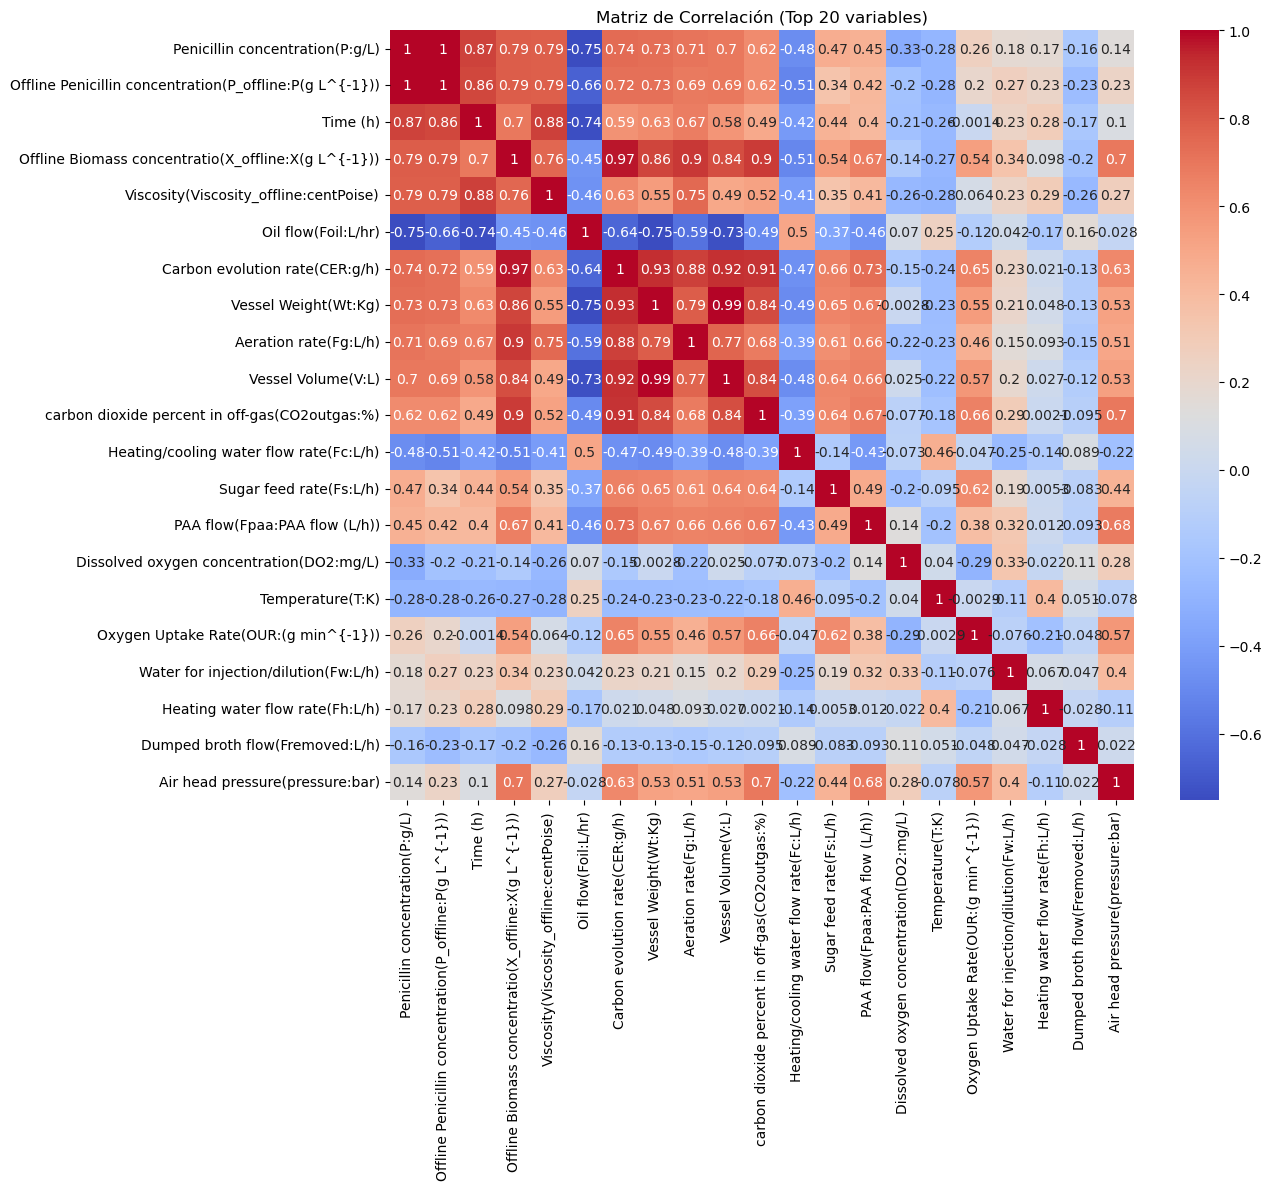

In [22]:
def cross_validation(X, y):
    gkf = GroupKFold(n_splits=5)
    ridge = Ridge(alpha=1.0)
    r2_scores = [r2_score(y.iloc[test], ridge.fit(X.iloc[train], y.iloc[train]).predict(X.iloc[test])) for train, test in gkf.split(X, y, groups=X.index)]
    print(f"R² promedio en validación cruzada: {np.mean(r2_scores)}")
    return np.mean(r2_scores)

r2_cv = cross_validation(X, y)

# 14. Visualización de la correlación
plt.figure(figsize=(12, 10))
sns.heatmap(df_selected.corr(), cmap='coolwarm', annot=True)
plt.title('Matriz de Correlación (Top 20 variables)')
plt.show()
